<a href="https://colab.research.google.com/github/sourabhx003/Projects/blob/main/Internship_Research_Paper_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome to the Research Paper Implimentation **

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,LeakyReLU,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

Loading the data viz: data of ipls played.Data is stored per ball way which means it has some values for every deliveries delivered during during these ipl seasons.


In [2]:
#Dataset is a kaggle dataset contains ipl matches from 2008 to 2018

In [3]:
from google.colab import files
uploaded = files.upload()

Saving deliveries.csv to deliveries.csv


In [59]:
dataset = pd.read_csv("./deliveries.csv")
dataset.head(5)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


In [60]:
dataset.isnull().any()

match_id            False
inning              False
batting_team        False
bowling_team        False
over                False
ball                False
batsman             False
non_striker         False
bowler              False
is_super_over       False
wide_runs           False
bye_runs            False
legbye_runs         False
noball_runs         False
penalty_runs        False
batsman_runs        False
extra_runs          False
total_runs          False
player_dismissed     True
dismissal_kind       True
fielder              True
dtype: bool

Here the dataset contains a lot of "Nan" in player_dismissed which is one of the main feature which will help to predict the run which is to be scored in the next deliveries 

In [61]:
dataset["player_dismissed"] = dataset["player_dismissed"].replace(np.nan,0)

In [62]:
#Here every dismissed is set to "1" using regular expression which will help in predicting the output

In [63]:
dataset["player_dismissed"] = dataset["player_dismissed"].replace('\D*',1,regex=True)

In [64]:
dataset.head(120)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,0,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,19,3,Yuvraj Singh,DJ Hooda,TS Mills,0,0,0,0,0,0,6,0,6,0,NaN,NaN
116,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,19,4,Yuvraj Singh,DJ Hooda,TS Mills,0,0,0,0,0,0,0,0,0,1,bowled,NaN
117,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,19,5,BCJ Cutting,DJ Hooda,TS Mills,0,0,0,0,0,0,1,0,1,0,NaN,NaN
118,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,19,6,DJ Hooda,BCJ Cutting,TS Mills,0,0,0,0,0,0,0,0,0,0,NaN,NaN


In [65]:
dataset.describe()

,match_id,inning,over,ball,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed
count,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000,164750.000000
mean,977.951757,1.482307,10.151879,3.616243,0.000492,0.037184,0.004898,0.021548,0.004200,0.000061,1.237238,0.067891,1.305129,0.049511
std,2147.671843,0.501592,5.675666,1.807398,0.022168,0.254087,0.115006,0.196410,0.071111,0.017421,1.603511,0.345144,1.596255,0.216934
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,175.000000,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,349.000000,1.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,521.000000,2.000000,15.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,7953.000000,4.000000,20.000000,9.000000,1.000000,5.000000,4.000000,5.000000,5.000000,5.000000,7.000000,7.000000,10.000000,1.000000


In [66]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164750 entries, 0 to 164749
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          164750 non-null  int64 
 1   inning            164750 non-null  int64 
 2   batting_team      164750 non-null  object
 3   bowling_team      164750 non-null  object
 4   over              164750 non-null  int64 
 5   ball              164750 non-null  int64 
 6   batsman           164750 non-null  object
 7   non_striker       164750 non-null  object
 8   bowler            164750 non-null  object
 9   is_super_over     164750 non-null  int64 
 10  wide_runs         164750 non-null  int64 
 11  bye_runs          164750 non-null  int64 
 12  legbye_runs       164750 non-null  int64 
 13  noball_runs       164750 non-null  int64 
 14  penalty_runs      164750 non-null  int64 
 15  batsman_runs      164750 non-null  int64 
 16  extra_runs        164750 non-null  int

In [67]:
dataset.corr()

,match_id,inning,over,ball,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed
match_id,1.000000,0.000848,0.005602,-0.000620,-0.006912,-0.004388,0.000018,-0.011610,-0.006824,-0.001149,0.030315,-0.011295,0.028011,0.000795
inning,0.000848,1.000000,-0.050410,-0.003841,0.087851,0.000733,-0.000865,-0.002168,-0.000469,0.003596,-0.005675,-0.000898,-0.005895,-0.000902
over,0.005602,-0.050410,1.000000,-0.009225,-0.035763,-0.013433,0.012269,-0.004814,0.016662,-0.001014,0.087639,-0.005158,0.086922,0.073475
ball,-0.000620,-0.003841,-0.009225,1.000000,-0.001199,-0.004905,0.008080,-0.003602,0.001443,0.000740,0.008633,-0.002634,0.008103,0.004494
is_super_over,-0.006912,0.087851,-0.035763,-0.001199,1.000000,-0.001090,0.001436,0.001749,0.014092,-0.000077,0.010721,0.003571,0.011542,0.012609
wide_runs,-0.004388,0.000733,-0.013433,-0.004905,-0.001090,1.000000,-0.006233,-0.016055,-0.008644,0.013203,-0.102725,0.723848,0.053319,-0.030207
bye_runs,0.000018,-0.000865,0.012269,0.008080,0.001436,-0.006233,1.000000,-0.004673,-0.002516,-0.000148,-0.025754,0.325439,0.044496,-0.009721
legbye_runs,-0.011610,-0.002168,-0.004814,-0.003602,0.001749,-0.016055,-0.004673,1.000000,-0.006480,-0.000382,-0.078231,0.554336,0.041272,-0.024327
noball_runs,-0.006824,-0.000469,0.016662,0.001443,0.014092,-0.008644,-0.002516,-0.006480,1.000000,-0.000206,0.001269,0.195132,0.043466,-0.012301
penalty_runs,-0.001149,0.003596,-0.001014,0.000740,-0.000077,0.013203,-0.000148,-0.000382,-0.000206,1.000000,-0.002688,0.059885,0.010248,-0.000795


**Dataset.corr() will give how much the data is dependent to other value i.e nearer to zero are less likely to make impact into prediction whereas if the value is close to -1 or 1 the are pretty much largly impacting the prediction**

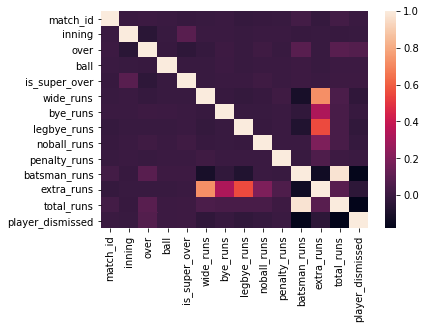

In [68]:
sb.heatmap(dataset.corr())

Our model will predict the real the real world data so it is impossible to find the extra runs or the type of run which is to be played in the delivery which we're going to predict.
 So to avoid this cause we'll be dealing with the real world we have to drop these Series

In [69]:
dataset = dataset.drop(["wide_runs","bye_runs","legbye_runs","noball_runs","penalty_runs","batsman_runs","extra_runs"],axis=1)

In [70]:
dataset

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,4,0,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164745,7953,2,Chennai Super Kings,Sunrisers Hyderabad,18,5,SR Watson,AT Rayudu,S Kaul,0,4,0,NaN,NaN
164746,7953,2,Chennai Super Kings,Sunrisers Hyderabad,18,6,SR Watson,AT Rayudu,S Kaul,0,0,0,NaN,NaN
164747,7953,2,Chennai Super Kings,Sunrisers Hyderabad,19,1,AT Rayudu,SR Watson,CR Brathwaite,0,0,0,NaN,NaN
164748,7953,2,Chennai Super Kings,Sunrisers Hyderabad,19,2,AT Rayudu,SR Watson,CR Brathwaite,0,0,0,NaN,NaN


In [71]:
dataset = dataset.drop(["dismissal_kind","fielder"],axis=1)

**Not we have 4 categorical values which can be converted to onehotencode values or dummy values but setting (batsman name/non striker) to onehotencoded value will be highly computationally expensive cause for every 1 computation we have to compute atleast(100 values) cause number batsman will be greater than 100 it is hard to have 100 values**

In [72]:
dataset = dataset.drop(["batsman","non_striker"],axis=1)

In [73]:
dataset["bowler"].unique()

array(['TS Mills', 'A Choudhary', 'YS Chahal', 'S Aravind', 'SR Watson',
       'TM Head', 'STR Binny', 'A Nehra', 'B Kumar', 'BCJ Cutting',
       'Rashid Khan', 'DJ Hooda', 'MC Henriques', 'Bipul Sharma',
       'AB Dinda', 'DL Chahar', 'BA Stokes', 'Imran Tahir', 'A Zampa',
       'R Bhatia', 'TG Southee', 'HH Pandya', 'MJ McClenaghan',
       'JJ Bumrah', 'KH Pandya', 'KA Pollard', 'TA Boult', 'PP Chawla',
       'SP Narine', 'CR Woakes', 'Kuldeep Yadav', 'YK Pathan', 'P Kumar',
       'DS Kulkarni', 'MS Gony', 'S Kaushik', 'DR Smith', 'SB Jakati',
       'Sandeep Sharma', 'MM Sharma', 'AR Patel', 'T Natarajan',
       'MP Stoinis', 'Swapnil Singh', 'DT Christian', 'RD Chahar',
       'Z Khan', 'CH Morris', 'PJ Cummins', 'S Nadeem', 'A Mishra',
       'CR Brathwaite', 'B Stanlake', 'Iqbal Abdulla', 'P Negi',
       'SK Raina', 'Tejas Baroka', 'Basil Thampi', 'SL Malinga',
       'Harbhajan Singh', 'AS Rajpoot', 'VR Aaron', 'CJ Anderson',
       'Mustafizur Rahman', 'UT Yadav', 'C d

**As we can see that number of bowlers are too much to convert them into one hot encoded values**

In [74]:
dataset.drop(["bowler"],axis=1,inplace=True)

In [75]:
dataset

,match_id,inning,batting_team,bowling_team,over,ball,is_super_over,total_runs,player_dismissed
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,0,0,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,0,0,0
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,0,4,0
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,0,0,0
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,0,2,0
...,...,...,...,...,...,...,...,...,...
164745,7953,2,Chennai Super Kings,Sunrisers Hyderabad,18,5,0,4,0
164746,7953,2,Chennai Super Kings,Sunrisers Hyderabad,18,6,0,0,0
164747,7953,2,Chennai Super Kings,Sunrisers Hyderabad,19,1,0,0,0
164748,7953,2,Chennai Super Kings,Sunrisers Hyderabad,19,2,0,0,0


In [76]:
dataset.corr()

,match_id,inning,over,ball,is_super_over,total_runs,player_dismissed
match_id,1.000000,0.000848,0.005602,-0.000620,-0.006912,0.028011,0.000795
inning,0.000848,1.000000,-0.050410,-0.003841,0.087851,-0.005895,-0.000902
over,0.005602,-0.050410,1.000000,-0.009225,-0.035763,0.086922,0.073475
ball,-0.000620,-0.003841,-0.009225,1.000000,-0.001199,0.008103,0.004494
is_super_over,-0.006912,0.087851,-0.035763,-0.001199,1.000000,0.011542,0.012609
total_runs,0.028011,-0.005895,0.086922,0.008103,0.011542,1.000000,-0.180754
player_dismissed,0.000795,-0.000902,0.073475,0.004494,0.012609,-0.180754,1.000000


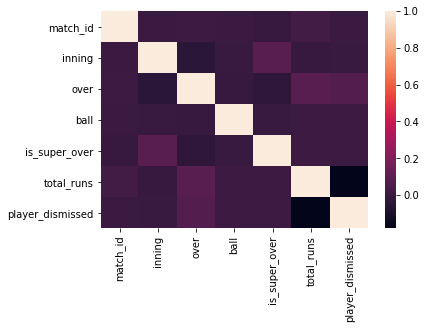

In [77]:
sb.heatmap(dataset.corr())

(<function matplotlib.pyplot.figure>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd125e95f28>,
       dtype=object))

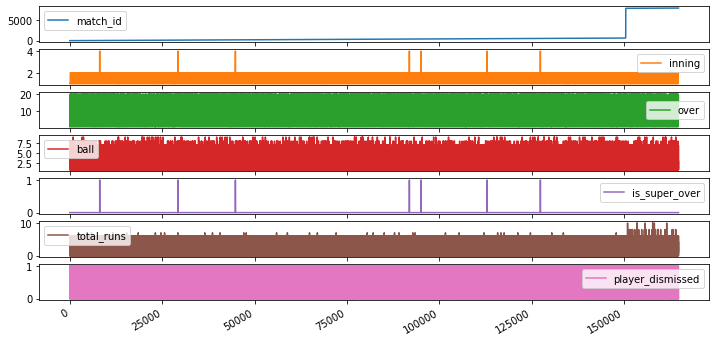

In [78]:
plt.figure,dataset.plot(subplots=True,figsize=(12,6))

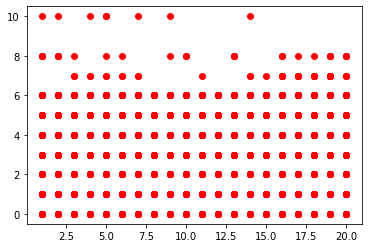

In [79]:
plt.scatter(dataset["over"],dataset["total_runs"],color="r")

In [80]:
dataset

,match_id,inning,batting_team,bowling_team,over,ball,is_super_over,total_runs,player_dismissed
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,0,0,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,0,0,0
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,0,4,0
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,0,0,0
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,0,2,0
...,...,...,...,...,...,...,...,...,...
164745,7953,2,Chennai Super Kings,Sunrisers Hyderabad,18,5,0,4,0
164746,7953,2,Chennai Super Kings,Sunrisers Hyderabad,18,6,0,0,0
164747,7953,2,Chennai Super Kings,Sunrisers Hyderabad,19,1,0,0,0
164748,7953,2,Chennai Super Kings,Sunrisers Hyderabad,19,2,0,0,0


**Now we have to encode batting team and bowling team into OneHOtEncoder**

In [81]:
ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(dataset[["batting_team","bowling_team"]]).toarray()
feature_labels = ohe.categories_

In [82]:
feature_arr.shape,feature_arr

((164750, 28), array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.]]))

In [83]:
feature_labels

[array(['Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredevils',
        'Gujarat Lions', 'Kings XI Punjab', 'Kochi Tuskers Kerala',
        'Kolkata Knight Riders', 'Mumbai Indians', 'Pune Warriors',
        'Rajasthan Royals', 'Rising Pune Supergiant',
        'Rising Pune Supergiants', 'Royal Challengers Bangalore',
        'Sunrisers Hyderabad'], dtype=object),
 array(['Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredevils',
        'Gujarat Lions', 'Kings XI Punjab', 'Kochi Tuskers Kerala',
        'Kolkata Knight Riders', 'Mumbai Indians', 'Pune Warriors',
        'Rajasthan Royals', 'Rising Pune Supergiant',
        'Rising Pune Supergiants', 'Royal Challengers Bangalore',
        'Sunrisers Hyderabad'], dtype=object)]

In [84]:
dataset = dataset.drop(["batting_team","bowling_team"],axis=1)

In [86]:
dataset

,match_id,inning,over,ball,is_super_over,total_runs,player_dismissed
0,1,1,1,1,0,0,0
1,1,1,1,2,0,0,0
2,1,1,1,3,0,4,0
3,1,1,1,4,0,0,0
4,1,1,1,5,0,2,0
...,...,...,...,...,...,...,...
164745,7953,2,18,5,0,4,0
164746,7953,2,18,6,0,0,0
164747,7953,2,19,1,0,0,0
164748,7953,2,19,2,0,0,0


In [88]:
number_outputs = len(dataset["total_runs"].unique())

In [89]:
data_output = dataset.pop("total_runs")
data_inputs = dataset

In [90]:
type(data_output)

pandas.core.series.Series

In [91]:
data_inputs

,match_id,inning,over,ball,is_super_over,player_dismissed
0,1,1,1,1,0,0
1,1,1,1,2,0,0
2,1,1,1,3,0,0
3,1,1,1,4,0,0
4,1,1,1,5,0,0
...,...,...,...,...,...,...
164745,7953,2,18,5,0,0
164746,7953,2,18,6,0,0
164747,7953,2,19,1,0,0
164748,7953,2,19,2,0,0


In [92]:
data_inputs = data_inputs.iloc[:,:].values
data_output = data_output.iloc[:].values

In [93]:
data_inputs = np.concatenate([data_inputs,feature_arr],axis=1)
data_inputs

array([[1.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [7.953e+03, 2.000e+00, 1.900e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [7.953e+03, 2.000e+00, 1.900e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [7.953e+03, 2.000e+00, 1.900e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

Now we have all the data we need we just have to convert it into numpy values

In [94]:
type(data_inputs),type(data_output)

(numpy.ndarray, numpy.ndarray)

In [95]:
data_inputs.shape,data_output.shape

((164750, 34), (164750,))

In [96]:
SPLIT_POINT = 0.9
split_number = int(data_inputs.shape[0] * 0.9)
train_ip = data_inputs[:split_number,:]
train_op = data_output[:split_number]
test_ip = data_inputs[split_number:,:]
test_op = data_output[split_number:]

In [97]:
train_ip.shape,train_op.shape

((148275, 34), (148275,))

In [98]:
test_ip.shape,test_op.shape

((16475, 34), (16475,))

**Now we have everything we got all the data and now all we have to do is to make a function that will take data_inputs as an input and data_output as an output**

To approach this problem we have to solutions either by forcasting or using an Long Short Term Memory cell with dense layers

Here we will simply use LSTM approach 

**But in case of forecasting and using LSTM there are alot to hyperparameters to tune that is batch size,window size in addition to the hyperparaters like number of epochs,learning rate,beta1,beta2**

In [100]:
batch_size = 256
optmizer = Adam(learning_rate = 1e-7,epsilon=1e-05)
epochs = 15 
number_of_outputs = number_outputs

In [161]:
model = Sequential([
                    keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=-1),input_shape=[34]),
                    LSTM(256,return_sequences=True,recurrent_dropout=0.2),
                    Dropout(0.2),
                    BatchNormalization(),
                    LSTM(128,recurrent_dropout=0.2),
                    BatchNormalization(),
                    Dense(256,activation="relu"),
                    Dense(128,activation="relu"),
                    Dense(number_of_outputs,activation="softmax")
])

In [162]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 34, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 34, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 34, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 34, 256)           1024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 256)               3

In [154]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-07*10**(epoch/20))

We are using learning rate scheduler to find the optimal Learning rate at which our model converges to the local optimima quite fastly

In [163]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optmizer,
              metrics=["acc"],
              )

**Since our data in unbalanced using accuracy as the metric wouldnt be good thing to consider**

In [156]:
tf.keras.backend.clear_session()

In [157]:
#code for setting learning rate paramters
#history = model.fit(x=train_ip,y=train_op,callbacks=[lr_scheduler],epochs=100,shuffle=True,batch_size=batch_size)

Epoch 1/100
580/580 [==============================] - 117s 202ms/step - loss: 2.1961 - acc: 0.1703
Epoch 2/100
580/580 [==============================] - 118s 204ms/step - loss: 2.1711 - acc: 0.1914
Epoch 3/100
580/580 [==============================] - 116s 201ms/step - loss: 2.1487 - acc: 0.2132
Epoch 4/100
580/580 [==============================] - 117s 201ms/step - loss: 2.1279 - acc: 0.2332
Epoch 5/100
580/580 [==============================] - 115s 199ms/step - loss: 2.1039 - acc: 0.2560
Epoch 6/100
580/580 [==============================] - 116s 200ms/step - loss: 2.0789 - acc: 0.2772
Epoch 7/100
580/580 [==============================] - 117s 202ms/step - loss: 2.0514 - acc: 0.3013
Epoch 8/100
580/580 [==============================] - 119s 204ms/step - loss: 2.0192 - acc: 0.3262
Epoch 9/100
580/580 [==============================] - 116s 200ms/step - loss: 1.9827 - acc: 0.3499
Epoch 10/100
580/580 [==============================] - 115s 199ms/step - loss: 1.9432 - acc: 0.3710

KeyboardInterrupt: ignored

Plotting the learning rate with our metric to get a better intuition about what should be our learning rate.
This is a neat way to set learning rate hyperparamter

In [159]:
#code to find the optimun learning rate
#plt.semilogx(history.history["lr"],history.history["loss"])
#plt.axis([1e-8,1e-3,0,5])

Lets say we got optimal learning rate as 1e-06 

In [164]:
learning_rate = 1e-06

In [168]:
tf.keras.backend.clear_session()
history = model.fit(x=train_ip,y=train_op,epochs=50,shuffle=True,batch_size=batch_size)

PLotting loss and accuracy of the data.

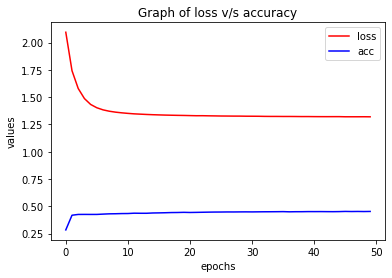

In [167]:
epoch = np.arange(0,50)
loss = history.history["loss"]
accuracy = history.history["acc"]
plt.plot(epoch,loss,"r-")
plt.plot(epoch,accuracy,"b-")
plt.xlabel("epochs")
plt.ylabel("values")
plt.title("Graph of loss v/s accuracy")
plt.legend(["loss","acc"])

In [169]:
model.evaluate(test_ip,test_op)

515/515 [==============================] - 10s 19ms/step - loss: nan - acc: 0.4245


[nan, 0.4245220124721527]

Since it a first gen Model and alot of hypermeters to tweak the model has a lot to possibilities to learn and a lot of possibilities to achieve a good accuracy score.
For the first model 42% isnt that bad to come up with the better models.
The model above is quite simple in nature with 2LSTM layers with Dropouts and BatchNOrmalization and some Dense Layer.So if the model will be complex or if we use forecasting technique the acuracy migth be quite higher than 42%.

Text(0.5, 1.0, 'LOss curve')

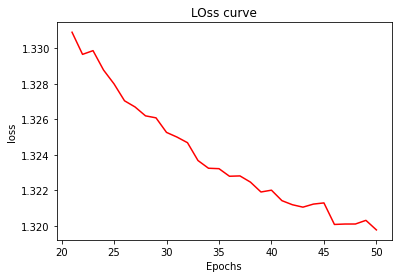

In [172]:
epoch = np.arange(21,51)
loss = history.history["loss"][20:]
plt.plot(epoch,loss,"r-")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("LOss curve")

**The above curves gives the sign of if the number of epochs were high the trend of our loss will be minimized further**

Text(0.5, 1.0, 'Accuracy curve')

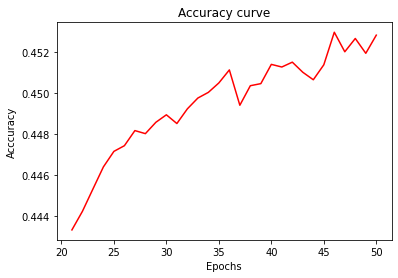

In [173]:
epoch = np.arange(21,51)
loss = history.history["acc"][20:]
plt.plot(epoch,loss,"r-")
plt.xlabel("Epochs")
plt.ylabel("Acccuracy")
plt.title("Accuracy curve")

**With higher number of epochs the our model will do quite well with the accurate prediction**